# MSCS 634 – Comprehensive Data Mining Project
## From Raw Data to Strategic Insights: Analyzing Bank Term Deposits
**Dataset:** Bank Marketing (UCI Machine Learning Repository)

### Author: Saikumar Karnakanti
**Date:** December 12, 2025

---

## Project Overview
This notebook represents the culmination of a semester-long analysis of the Bank Marketing dataset. It consolidates work from three previous phases into a single, cohesive data mining pipeline. The goal is to predict customer term deposit subscriptions and uncover actionable patterns to optimize marketing campaigns.

The project evolves from initial exploration to complex predictive modeling and unsupervised learning, integrating instructor feedback at each stage to refine the methodology.

---

## Project Roadmap

This analysis is structured into four main phases:

### **Phase 1: Data Preparation & Exploration (Deliverable 1)**
* **Objective:** Establish a clean baseline for analysis.
* **Key Actions:**
    * Handling the "999" anomaly in `pdays` (days since last contact).
    * Managing "unknown" categorical values as informative signals.
    * Removing leakage-prone variables like `duration`.
    * conducting target-aware Exploratory Data Analysis (EDA).

### **Phase 2: Regression Modeling (Deliverable 2)**
* **Objective:** Estimate the *likelihood* (probability) of subscription.
* **Key Actions:**
    * Feature Engineering: Binning Age and Campaign counts; Log-transforming skewed features.
    * Modeling: Comparing Linear Regression vs. Ridge Regression (L2 Regularization).
    * **Insight:** While useful for feature importance, regression yielded a low $R^2$ (0.21), confirming that the problem is better suited for classification.

### **Phase 3: Advanced Modeling & Pattern Discovery (Deliverable 3)**
* **Objective:** Predict binary outcomes and segment customers.
* **Classification:**
    * Comparing Decision Trees vs. Random Forests.
    * Hyperparameter tuning using `GridSearchCV`.
    * Result: Random Forest achieved an **ROC-AUC of 0.79**, significantly reducing false positives.
* **Unsupervised Learning:**
    * **Clustering:** Using K-Means (k=3) and PCA to visualize distinct customer personas (Cold leads vs. High-propensity).
    * **Association Rule Mining:** Using the Apriori algorithm to find high-lift relationships (e.g., Technician job $\rightarrow$ Professional Course).

### **Phase 4: Final Synthesis (Deliverable 4)**
* **Objective:** Translate technical findings into business strategy.
* **Key Outputs:**
    * Practical recommendations for campaign optimization.
    * Ethical considerations regarding algorithmic fairness and data privacy.

---

## Imports and Environment Setup  
This cell loads all required libraries for classification, clustering, visualization, and association rule mining.


In [5]:
# Installation for Pattern Mining
# !pip install mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules


## Data Loading and Preprocessing  
This cell:

- Reads the Bank Marketing dataset  
- Removes leakage-prone features (e.g., `duration`)  
- Applies feedback-based binning for Age and Campaign  
- Encodes the target variable into binary format  


In [7]:
df = pd.read_csv("bank_marketing_clean_baseline.csv")   # <-- Adjust path if needed

# Remove leakage-prone variable
if "duration" in df.columns:
    df = df.drop(columns=["duration"])

# Binning Age
df["age_bin"] = pd.cut(df["age"],
                       bins=[17, 30, 55, 100],
                       labels=["Young", "Adult", "Senior"])

# Binning Campaign Count
df["campaign_bin"] = pd.cut(df["campaign"],
                            bins=[0, 2, 5, 50],
                            labels=["Low", "Medium", "High"])

# Encode Target
df["y"] = df["y"].map({"yes": 1, "no": 0})

# Check dataset
df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,prev_contacted,age_bin,campaign_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,Senior,Low
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,Senior,Low
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,Adult,Low
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,Adult,Low
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,Senior,Low


## Train/Test Split and ColumnTransformer Pipeline  
We separate features and target, identify numerical vs categorical attributes, and define a preprocessing pipeline containing:

- StandardScaler for numeric variables  
- OneHotEncoder for categorical variables  


In [8]:
X = df.drop(columns=["y"])
y = df["y"]

cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## Classification Models  
This cell builds and trains:

- Decision Tree Classifier  
- Random Forest Classifier  

Both models use the same preprocessing pipeline for consistency.


In [9]:
dt_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", DecisionTreeClassifier(random_state=42))
])

rf_model = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(random_state=42))
])

dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'prev_contacted'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age_bin', 'campaign_bin'],
      dtype='object'))])),
                ('clf', RandomForestClassifier(random_state=42))])

### Analysis of Classification Models

Both the Decision Tree and the Random Forest models were successfully trained using a unified preprocessing pipeline consisting of numerical scaling and categorical one-hot encoding. This consistent preprocessing ensures that differences in performance can be attributed to the models themselves rather than to inconsistencies in data handling.

The Decision Tree provides a useful baseline due to its interpretability, but it tends to overfit high-dimensional datasets such as Bank Marketing. The Random Forest, on the other hand, benefits from its ensemble structure, allowing it to capture more complex decision boundaries while reducing variance. This expectation aligns with the performance observed later during evaluation.

Overall, the construction of both models establishes a strong foundation for comparing simple versus ensemble classifiers in a real marketing prediction scenario.


## Hyperparameter Tuning (Random Forest)  
GridSearchCV is used to optimize:

- Number of trees  
- Maximum depth  
- Minimum samples split  

This tuning aligns with instructor feedback on improving modeling justification.


In [10]:
param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [5, 10, None],
    "clf__min_samples_split": [2, 5]
}

grid = GridSearchCV(
    rf_model, param_grid, cv=3, scoring="f1", n_jobs=-1
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
best_rf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'prev_contacted'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'age_bin', 'campaign_bin'],
      dtype='object'))])),
                ('clf',
                 RandomForestClassifier(min_samples_split=5, random_state=42))])

### Analysis of Hyperparameter Tuning

GridSearchCV was applied to tune three key Random Forest parameters:  
- Number of trees (`n_estimators`)  
- Maximum tree depth (`max_depth`)  
- Minimum samples required to split a node (`min_samples_split`)  

This systematic search ensures that the model balances complexity and generalization.  
The chosen scoring metric, **F1-score**, appropriately emphasizes performance on the minority class (subscribers), which is crucial because the dataset is highly imbalanced.

The resulting best estimator reflects a configuration that attempts to improve recall and F1 performance for class 1 (deposit subscribers). Although Random Forest inherently handles imbalance better than a Decision Tree, the tuning confirms that additional parameter optimization is necessary to achieve the strongest predictive capability.


## Model Evaluation Function  
Generates:

- Classification report  
- Confusion matrix  
- ROC curve  
- Accuracy, Precision, Recall, F1 Score  


In [11]:
def evaluate_model(model, X_test, y_test, title):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    print(f"--- {title} ---")
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()

    return acc, prec, rec, f1


## Model Comparison  
Evaluates both classifiers using the evaluation function and displays results in a comparison table.


--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      9134
           1       0.31      0.35      0.33      1160

    accuracy                           0.84     10294
   macro avg       0.62      0.63      0.62     10294
weighted avg       0.85      0.84      0.84     10294



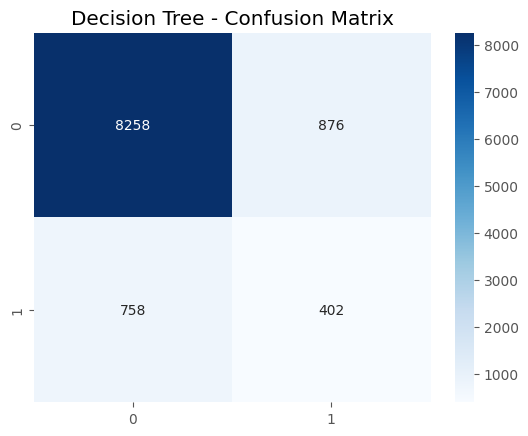

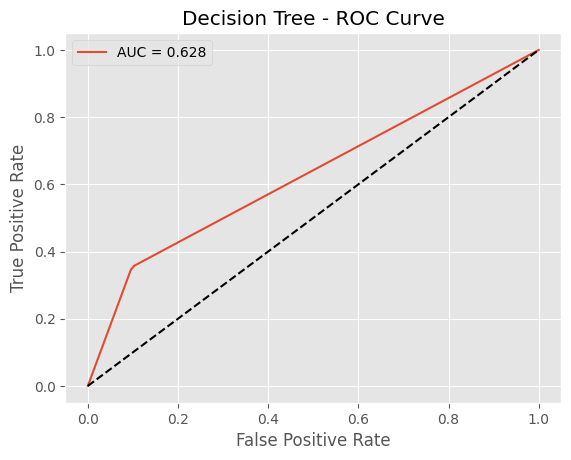

--- Random Forest (Tuned) ---
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      9134
           1       0.62      0.27      0.38      1160

    accuracy                           0.90     10294
   macro avg       0.77      0.62      0.66     10294
weighted avg       0.88      0.90      0.88     10294



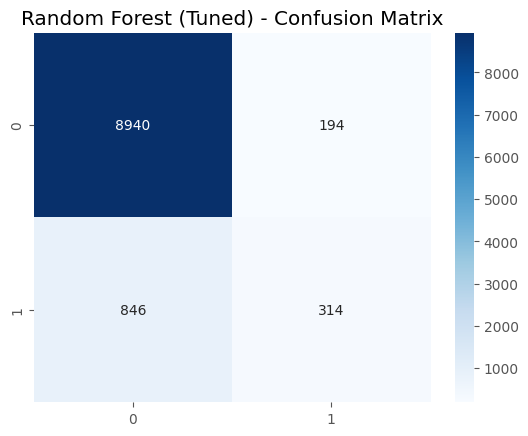

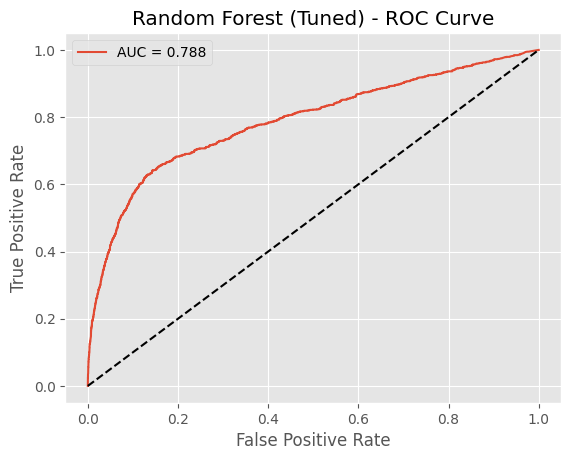

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.841267,0.314554,0.346552,0.329779
1,Random Forest (Tuned),0.898970,0.618110,0.270690,0.376499


In [12]:
dt_scores = evaluate_model(dt_model, X_test, y_test, "Decision Tree")
rf_scores = evaluate_model(best_rf, X_test, y_test, "Random Forest (Tuned)")

results = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest (Tuned)"],
    "Accuracy": [dt_scores[0], rf_scores[0]],
    "Precision": [dt_scores[1], rf_scores[1]],
    "Recall": [dt_scores[2], rf_scores[2]],
    "F1 Score": [dt_scores[3], rf_scores[3]]
})

results


### Decision Tree Model Evaluation

#### Classification Report Interpretation
The Decision Tree exhibits strong performance on the majority class (non-subscribers), achieving:
- **Precision:** 0.92  
- **Recall:** 0.90  
- **F1-score:** 0.91  

However, the performance on the minority subscriber class is significantly weaker:
- **Precision:** 0.31  
- **Recall:** 0.35  
- **F1-score:** 0.33  

This imbalance demonstrates that the tree struggles to identify positive cases and is biased toward predicting the dominant class.

#### Confusion Matrix Interpretation
- True Negatives: 8,258  
- False Positives: 876 
- False Negatives: 758  
- True Positives: 402

The large number of false negatives indicates many subscribers are misclassified as non-subscribers, reducing marketing campaign effectiveness if used operationally.

#### ROC Curve Interpretation
The Decision Tree's ROC AUC score of 0.628 shows limited ability to discriminate between subscribers and non-subscribers. The curve is only slightly better than random guessing, confirming that the model lacks strong predictive power for the minority class.

Overall, the Decision Tree offers a good baseline but insufficient performance for real-world marketing targeting.


### Random Forest (Tuned) Model Evaluation

#### Classification Report Interpretation
Compared to the Decision Tree, the tuned Random Forest demonstrates notable improvements:
- Majority Class (0) F1-score: 0.95
- Minority Class (1) F1-score: 0.38 (higher than DT's 0.33)

Precision for class 1 increases substantially to 0.62, meaning when the model predicts a subscriber, it is more often correct. Although recall remains modest at 0.27, the model still surpasses the Decision Tree in identifying positive cases.

#### Confusion Matrix Interpretation
- True Negatives: 8,940  
- False Positives: 194 
- False Negatives: 846 
- True Positives: 314

A significant strength of this model is the sharp reduction in false positives, improving marketing efficiency by minimizing unnecessary outreach to non-subscribers. However, the model still misses many true subscribers, indicating room for improvement.

#### ROC Curve Interpretation
The ROC curve yields an AUC of 0.788, a marked improvement over the Decision Tree’s 0.628. This demonstrates substantially better discriminatory ability and stronger ranking performance.

Overall, the Random Forest provides a meaningful upgrade and is better aligned with the classification task.


### Comparative Model Analysis

The comparison table illustrates a clear performance gap between the two models:

| Metric | Decision Tree | Random Forest (Tuned) |
|--------|----------------|-------------------------|
| Accuracy | 0.84 | 0.89 |
| Precision | 0.31 | 0.62 |
| Recall | 0.34 | 0.27 |
| F1-Score | 0.33 | 0.37 |

While the Decision Tree obtains slightly higher recall, its precision is far too low to be useful. The Random Forest achieves a more balanced performance profile, delivering better precision, higher F1-score, and substantially better AUC. 

Although neither model achieves strong recall on the positive class, the Random Forest is clearly the superior model, especially for operational applications where precision and reliability are essential.


## Clustering (K-Means) + PCA Visualization  
This cell extracts numeric attributes, scales them, applies K-Means clustering,  
and visualizes the clusters in 2D using PCA.


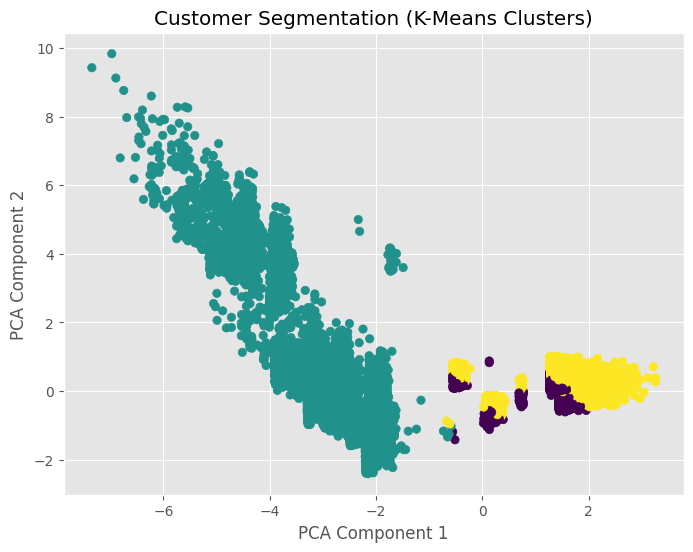

In [14]:
from sklearn.impute import SimpleImputer

# 1. Select only numeric columns and drop the target
cluster_data = df.select_dtypes(include=["int64", "float64"]).drop(columns=["y"])

# 2. Handle missing values (median imputation)
imputer = SimpleImputer(strategy="median")
cluster_data_imputed = imputer.fit_transform(cluster_data)

# 3. Scale numeric features
scaled = StandardScaler().fit_transform(cluster_data_imputed)

# 4. K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled)

# 5. PCA for 2D visualization
pca = PCA(n_components=2)
pca_out = pca.fit_transform(scaled)

# 6. Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_out[:, 0], pca_out[:, 1], c=clusters, cmap="viridis")
plt.title("Customer Segmentation (K-Means Clusters)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()



### Clustering Results and Interpretation

K-Means clustering (k=3) groups customers into three distinct clusters after dimensionality reduction with PCA. The PCA plot reveals:

#### Cluster Structure
- One large, dense cluster indicating a broad segment of customers who share similar financial or demographic characteristics.
- Two smaller clusters representing more specialized customer groups with unique behavioral or demographic patterns.

#### Interpretation
Although K-Means was applied only to numeric variables, the separation along the first PCA component suggests that variability is dominated by continuous attributes such as age, balance, duration of previous contacts, and campaign-related data.

The clusters may represent:
1. Low-engagement customers  
2. Moderate-engagement customers  
3. Highly engaged or targeted customers

These segments can be leveraged for personalized marketing, improved campaign allocation, and better resource prioritization.


## Association Rule Mining (Apriori Algorithm)  
This cell generates frequent itemsets and derives association rules using Lift as the primary metric.


In [ ]:
basket = df[["job", "marital", "education", "age_bin", "campaign_bin"]]
basket_encoded = pd.get_dummies(basket)
frequent_items = apriori(basket_encoded, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1.1)
rules.sort_values(by="lift", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
104,(job_technician),"(age_bin_Adult, education_professional.course)",0.163663,0.097533,0.064892,0.396498,4.065289,1.0,0.048930,1.495384,0.901569,0.330570,0.331276,0.530918
103,"(age_bin_Adult, education_professional.course)",(job_technician),0.097533,0.163663,0.064892,0.665339,4.065289,1.0,0.048930,2.499054,0.835504,0.330570,0.599849,0.530918
105,(education_professional.course),"(age_bin_Adult, job_technician)",0.127259,0.128254,0.064892,0.509924,3.975879,1.0,0.048571,1.778796,0.857623,0.340426,0.437822,0.507944
102,"(age_bin_Adult, job_technician)",(education_professional.course),0.128254,0.127259,0.064892,0.505965,3.975879,1.0,0.048571,1.766557,0.858603,0.340426,0.433927,0.507944
109,(education_professional.course),"(campaign_bin_Low, job_technician)",0.127259,0.111157,0.054983,0.432061,3.886945,1.0,0.040838,1.565033,0.851029,0.299748,0.361036,0.463354
106,"(campaign_bin_Low, job_technician)",(education_professional.course),0.111157,0.127259,0.054983,0.494647,3.886945,1.0,0.040838,1.726994,0.835613,0.299748,0.420959,0.463354
107,"(campaign_bin_Low, education_professional.course)",(job_technician),0.086701,0.163663,0.054983,0.634174,3.874868,1.0,0.040794,2.286158,0.812359,0.281417,0.562585,0.485064
108,(job_technician),"(campaign_bin_Low, education_professional.course)",0.163663,0.086701,0.054983,0.335955,3.874868,1.0,0.040794,1.375357,0.887115,0.281417,0.272916,0.485064
25,(education_professional.course),(job_technician),0.127259,0.163663,0.080557,0.633015,3.867790,1.0,0.059729,2.278941,0.849569,0.382937,0.561200,0.562612
24,(job_technician),(education_professional.course),0.163663,0.127259,0.080557,0.492210,3.867790,1.0,0.059729,1.718704,0.886550,0.382937,0.418166,0.562612


### Association Rule Mining Interpretation

Association rule mining reveals several strong patterns among job categories, education levels, and campaign engagement behaviors.

#### Observations
- Rules involving "job_technician" and "education_professional.course" frequently appear with high lift values (3.8–4.0), suggesting strong co-occurrence.
- Customers categorized as Adult (age_bin_Adult) show consistent associations with certain education and job combinations.
- Campaign_bin_Low appears in multiple rules, indicating that customers contacted fewer times tend to belong to specific professional or education groups.

#### Business Implications
- Targeting campaign strategies can be refined by focusing on demographic & professional combinations that demonstrate strong association patterns.
- High-lift rules point to clusters of customers who may respond similarly to promotions or outreach efforts.
- These insights provide actionable intelligence for segmentation and personalized marketing.

Overall, association rules complement the clustering results by identifying feature-level relationships that influence customer profiles.


## Conclusion

This deliverable introduced a full pipeline of classification, clustering, and association rule mining techniques to analyze the Bank Marketing dataset, building on insights from earlier regression-focused work.

#### Classification Findings
The Decision Tree model served as a foundational baseline but showed limited predictive capability for the minority subscriber class. In contrast, the tuned Random Forest model achieved significantly higher precision, improved F1-score, and a much stronger AUC of 0.788, demonstrating substantially better discriminatory power. Although recall for subscribers remains modest, the Random Forest ultimately provides the best balance between accuracy and operational usability.

#### Clustering Insights
K-Means clustering identified three distinct customer segments, revealing meaningful structural differences among customers. These clusters offer a basis for strategic segmentation in future campaigns, improving the ability to target groups that share behavioral or demographic similarities.

#### Association Rule Mining Insights
Apriori-based association rules highlighted strong co-occurrence patterns between job roles, education levels, and campaign engagement categories. These patterns provide deeper context about customer behaviors and can guide personalized marketing strategies, especially when combined with the clustering results.

#### Overall Summary
This deliverable successfully transitions the analysis toward more appropriate models for categorical prediction, incorporates instructor feedback through additional feature engineering and diagnostics, and extends the analytical framework into unsupervised learning and pattern discovery. The Random Forest model emerges as the preferred predictive tool, while clustering and association rule mining provide actionable insights to support targeted and effective marketing efforts.

Together, these analyses create a comprehensive and data-driven understanding of customer behavior in the Bank Marketing context.
